# Utils

In [3]:
import os
import cartopy
import cartopy.crs as ccrs
import cmcrameri.cm as cmc
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.stats import linregress
from typing import Tuple

In [25]:
ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"})
ds

<xarray.Dataset>
Dimensions:         (time: 2080, latitude: 36, longitude: 72, bnds: 2)
Coordinates:
  * time            (time) object 1850-01-16 12:00:00 ... 2023-04-16 00:00:00
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds
Data variables:
    sst             (time, latitude, longitude) float32 ...
    time_bnds       (time, bnds) object ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

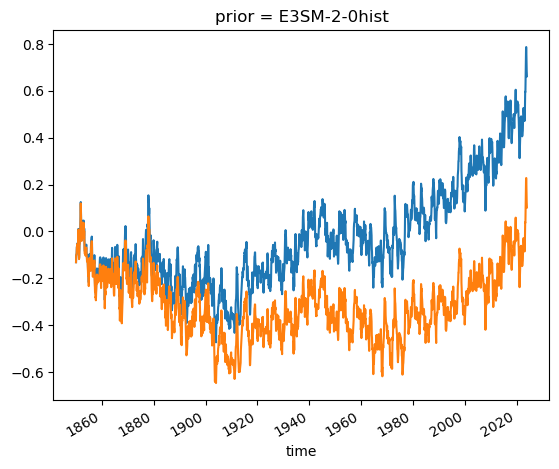

In [23]:
def detrend(da):
    time_idx = xr.DataArray(np.arange(len(da.time)), dims="time")
    slope = xscore.linslope(time_idx, da, dim="time", skipna=False)
    da = da - slope*time_idx
    return da 

vc = xr.open_dataset("/home/espinosa10/zac_20250220/sstanom_8priors_v0.nc")
gm_sst = vc.isel(prior=0)["tos"] #.plot()
gm_sst.mean(["lat", "lon"]).plot()
detrend(gm_sst).mean(["lat", "lon"]).plot()
vc["time"] = vc.time.values.astype('datetime64[M]')

In [10]:
def load_sst(product_name="ERA5", start_time="1850-01-01", end_time="2022-12-31") -> xr.Dataset:
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    
    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-ERSSTv5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, "2017-12-31"))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice("1982-01-01", end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc").sel(time=slice(start_time, "2017-12-31"))

    elif product_name == "HadISST-2.2":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "HadISST-2.3":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"}).sel(time=slice(start_time, "2019-12-31"))

    elif product_name == "HadSST4":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    else: 
        return

    return ds

# SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE2", "HadISST-2.2"]
SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadSST4", "HadISST-2.3", "HadISST-2.2"]
# SST_PRODUCTS = ["ERA5", "COBE", "COBE2", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0", "HadISST-1.1", "HadSST4", "PCMDI-AMIP-1-1-9"]

for prod in SST_PRODUCTS:
    ds = load_sst(prod)
    print(f"{prod}: {ds.time.values[0]} - {ds.time.values[-1]}")

2025-02-27 13:15:34,483 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


NOAA-OISST-v2.1: 1982-01-01 00:00:00 - 2022-12-01 00:00:00
PCMDI-AMIP-1-1-9: 1870-01-16 12:00:00 - 2022-12-16 12:00:00
ERA5: 1979-01-01 00:00:00 - 2022-12-01 00:00:00
NOAA-ERSSTv5: 1854-01-01 00:00:00 - 2022-12-01 00:00:00


2025-02-27 13:15:34,782 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2025-02-27 13:15:34,877 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


COBE: 1891-01-01 00:00:00 - 2017-12-01 00:00:00
COBE2: 1850-01-01 00:00:00 - 2019-12-01 00:00:00
HadISST-1.1: 1870-01-16 11:59:59 - 2017-12-16 12:00:00
HadSST4: 1850-01-16 12:00:00 - 2022-12-16 12:00:00
HadISST-2.3: 1850-01-16 12:00:00 - 2019-12-16 12:00:00
HadISST-2.2: 1948-01-01 00:00:00 - 2015-12-01 00:00:00


In [2]:
def _global_plot(
    ax, 
    data, 
    lon, 
    lat, 
    cmap, 
    pvalues=None, 
    right_title="", 
    left_title="", 
    levels=np.arange(-4, 4.1, .1), 
    cbar_label: str = "",
    contours=None,
    pr=None,
    wind=None,
):
    # plot map of global data with central longitude 180
    # Uncomment for reds
    # cmap = matplotlib.cm.get_cmap(cmap)
    # norm = matplotlib.colors.Normalize(vmin=np.min(levels), vmax=np.max(levels))
    # cmap = [cmap(norm(l)) for l in levels]
    # cmap[0] = (1, 1, 1, 1) # Set first element to white
    
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(),
        # colors=cmap, # uncomment for reds
        cmap=cmap,
        extend="both",
        levels=levels,
    )
    if contours is not None:
        contour_obj = ax.contour(
            lon, lat, contours,
            transform=ccrs.PlateCarree(),
            colors="black",
            # levels=[-600, -450, -300, -150, 0, 150, 300, 450, 600] # Contours for PSL
            levels=[-600, -450, -300, -150, -100, -50, 0, 50, 100, 150, 300, 450, 600] # Contours for PSL
            # levels=[-650,-500, -350, -200, -150, -100, -50, 0, 50, 100, 150, 200, 350, 500, 650] # Contours for PSL
        )
        # print("Contour levels:", contour_obj.levels)
    if pr is not None:
        ax.contour(
            lon, lat, pr,
            transform=ccrs.PlateCarree(),
            # cmap="magenta",
            colors="magenta",
            # levels=[-2, -1.2, .4, .6],
            levels=[-6, 6],
        )
    
    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .10, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
    
    if wind is not None:
        # Scale reg maps 25 
        # q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], scale=150, headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        # Scale for Pr wind maps
        q = ax.quiver(lon[::3], lat[::3], wind["uas"][::3,::3], wind["vas"][::3,::3], headwidth=2, headlength=2, transform=ccrs.PlateCarree())
        ax.quiverkey(q, .9, -.15, .25, str(.25) + r' $\frac{m}{s}/\sigma$', labelpos='E', transform=ccrs.PlateCarree(), coordinates='axes')
        
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # Southern ITCZ 
    # bound_region(ax, lons=(-130, -80), lats=(-20, 0), color="black")

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -90, 45
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    # add cbar label to top of colorbar
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.030, pad=0.02)
    # cbar.ax.set_title(cbar_label, fontsize=10)

    return img

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    


In [3]:
min_year, max_year = 1, 30
months = np.arange(1, 12)
years = np.arange(min_year*12, (max_year+1)*12, 12)

def calculate_coupling_depending_on_time(
    so_ssts = None, 
    ept_ssts = None, 
    models = None,
):
    time = [*months, *years]
    reg_coeffs, rvalues, pvalues, variance_so, variance_ept = [], [], [], [], []
    for year in time:
        ts_so_ssts = get_rolling_timeseries(so_ssts, window=year, step=12, gradient=False)
        ts_ept_ssts = get_rolling_timeseries(ept_ssts, window=year, step=12, gradient=False)

        variance_ept.append(ts_ept_ssts.std(dim="time"))
        variance_so.append(ts_so_ssts.std(dim="time"))
        rvalues.append(xscore.pearson_r(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts, ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['years', 'model'], np.array(reg_coeffs))}, coords={'model': models, 'years': time})
    rvalues = xr.Dataset({'rvalues': (['years', 'model'], np.array(rvalues))}, coords={'model': models, 'years': time})
    pvalues = xr.Dataset({'pvalues': (['years', 'model'], np.array(pvalues))}, coords={'model': models, 'years': time})
    variance_so = xr.Dataset({'variance_so': (['years', 'model'], np.array(variance_so))}, coords={'model': models, 'years': time})
    variance_ept = xr.Dataset({'variance_ept': (['years', 'model'], np.array(variance_ept))}, coords={'model': models, 'years': time})

    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues, variance_so, variance_ept])
    return regs_dataset


def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data, include_T=True):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    if include_T: data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def fix_coords_no_space(data):
    data = data.bounds.add_bounds("T")
    return data

def get_triangle_mean(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ntime, nlat, nlon = tos.shape
    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[2]: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:nlats, i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
     
    return ctos

def get_rolling_timeseries(data: xr.DataArray, window: int = 12*30, step: int = 12, save: bool = False, name: str = "", gradient: bool = False) -> xr.DataArray:
    """Get the rolling timeseries of a dataset (optionally calculate gradient)

    Args:
        data (xr.DataArray): Input data.
        window (int, optional): Size of the rolling window. Defaults to 12*30.
        step (int, optional): Step size for each window. Defaults to 12.
        gradient (bool, optional): Calculate gradient if True, mean if False. Defaults to False.

    Returns:
        xr.DataArray: Resulting timeseries with same shape as input.
    """
    
    # Prepare output array with the same shape as input data
    new_time_size = 1 + (len(data.time) - window) // step
    rolling_shape = list(data.shape)
    rolling_shape[data.get_axis_num('time')] = new_time_size

    # Prepare output array with the adjusted shape
    rolling = np.full(rolling_shape, np.nan)
    time_idx = xr.DataArray(np.arange(window), dims="time")

    data = data.chunk({"time": -1})
    # Loop to compute rolling statistics over time dimension
    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if gradient:
            rolling[:,j] = window*xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=True).values
        else:
            rolling[:,j] = data.isel(time=slice(i, i+window)).mean(dim="time").values

    # Convert to xarray
    da = xr.DataArray(rolling, dims=data.dims, coords={**data.coords, 'time': np.arange(rolling.shape[1])})

    return da

def get_region_reg(cmip_region_ssts, cmip_regressor, window: float = 12*5):
    ts_region_ssts = get_rolling_timeseries(cmip_region_ssts, window=window, step=12, gradient=False)
    ts_cmip_reg = get_rolling_timeseries(cmip_regressor, window=window, step=12, gradient=False)

    reg_sst = xscore.linslope(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)

    pvalues_sst = xscore.pearson_r_eff_p_value(ts_region_ssts, ts_cmip_reg, dim="time", skipna=True)
    # pvalues_models = (pvalues_sst < .05).sum(dim="model") < ts_region_ssts.model.size/2 # This evaluates to 1 if more than half modes are sig

    return reg_sst, pvalues_sst

def preprocess(ds, varname):
    ds = remove_land_full(ds, var=varname).rename(varname).to_dataset()
    # print(ds)
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures(varname, "month", reference_period=("1990-01-01", "2010-12-31"))
    # Regrid to 2.5x2.5 degree grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    ds = ds.regridder.horizontal(varname, output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    return ds


# Load Obs

In [4]:
def detrend(da):
    time_idx = xr.DataArray(np.arange(len(da.time)), dims="time")
    slope = xscore.linslope(time_idx, da, dim="time", skipna=False)
    da = da - slope*time_idx
    return da 

In [ ]:
era5_u = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_u_component_of_wind.nc")
era5_v = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_10m_v_component_of_wind.nc")

era5_total_precip = fix_coords(xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_total_precipitation.nc"))
era5_total_precip = preprocess(era5_total_precip, "tp")
era5_total_precip = detrend(era5_total_precip["tp"]).rename("tp").to_dataset()

era5_msl = xr.open_dataset("/home/espinosa10/SO-EP-teleconnection/Data/ERA5/ERA5_monthly_1979-01_2023-12_mean_sea_level_pressure.nc")
era5_msl = preprocess(era5_msl.isel(expver=0).drop("expver"), "msl")
era5_msl = detrend(era5_msl["msl"].fillna(0)).rename("msl").to_dataset()
era5_msl = era5_msl.rename({"longitude": "lon", "latitude": "lat"})

# Calculate Walker Circulation
era5_msl = fix_coords(era5_msl)
west = era5_msl.sel(lat=slice(-5, 5), lon=slice(130, 150)).spatial.average("msl")["msl"]
east = era5_msl.sel(lat=slice(-5, 5), lon=slice(-180, -80)).spatial.average("msl")["msl"]
walker = fix_coords_no_space((east - west).to_dataset(name="walker"))
walker_anomaly = walker.temporal.departures("walker", "month")
walker_anomaly

In [6]:
SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE2", "HadISST-2.2"]
# SST_PRODUCTS = ["NOAA-OISST-v2.1", "PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE", "COBE2", "HadISST-1.1", "HadSST4", "HadISST-2.3", "HadISST-2.2"]
# SST_PRODUCTS = ["ERA5", "COBE", "COBE2", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0", "HadISST-1.1", "HadSST4", "PCMDI-AMIP-1-1-9"]

def load_sst(product_name="ERA5"):
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    
    # FULL TIME PERIOD
    start_time = "1850-01-01"
    end_time = "2022-12-31"

    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-ERSSTv5":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, "2017-12-31"))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        ds = xc.open_dataset("/home/espinosa10/tropical_pacific_clouds/data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice("1982-01-01", end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc").sel(time=slice(start_time, "2017-12-31"))

    elif product_name == "HadISST-2.2":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "HadISST-2.3":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"}).sel(time=slice(start_time, "2019-12-31"))

    elif product_name == "HadSST4":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    else: 
        return
    
    ###### PREPROCESSING ######
    ds = remove_land_full(ds, var="sst").rename("sst").to_dataset()
    # print(ds)
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures("sst", "month") #, reference_period=("1990-01-01", "2010-12-31"))
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal("sst", output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    # Detrend
    # ds["time"] = ssts.indexes["time"].to_datetimeindex().values.astype('datetime64[M]')
    time_idx = xr.DataArray(np.arange(len(ds.time)), dims="time")
    ssts_slope = xscore.linslope(time_idx, ds["sst"], dim="time", skipna=False)
    ds["sst"] = ds["sst"] - ssts_slope*time_idx
    

    # Get SST Anomalies in Triangular Region
    latmin, latmax = -38.75, -1.25
    lonmin, lonmax = -178.75, -71.25
    RES = 2.5
    ept = get_triangle_mean(ds["sst"].copy(), latmin, latmax, lonmin, lonmax, RES)
    ept_mean  = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

    # Get SST Anomlies in Southern Ocean
    so_mean = ds["sst"].sel(longitude=slice(-180, -75), latitude=slice(-70, -50))
    so_mean = (fix_coords(so_mean.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

    # Calculate WE Gradient
    west = fix_coords(ds["sst"].rename("tos").to_dataset()).sel(latitude=slice(-5, 5), longitude=slice(110, 150)).spatial.average("tos")["tos"]
    east = fix_coords(ds["sst"].rename("tos").to_dataset()).sel(latitude=slice(-5, 5), longitude=slice(-180, -80)).spatial.average("tos")["tos"]
    WE_sst = fix_coords_no_space((west - east).to_dataset(name="WE_sst"))
    WE_sst_anomaly = WE_sst.temporal.departures("WE_sst", "month")["WE_sst"]
    print(WE_sst_anomaly)


    return ds, so_mean, ept_mean, WE_sst_anomaly

In [10]:
def process_obs_data(save_path: str):
    obs_sst_so_ept_reg = []
    obs_sst_reg, obs_psl_reg, obs_pr_reg = [], [], []
    obs_sst_timeseries = []
    obs_walker_so_reg, obs_we_so_reg = [], []

    for i, sst_product in enumerate(SST_PRODUCTS): 
        print(f"Processing {sst_product}")
        ssts, so_mean, ept_mean, WE_sst_anomaly = load_sst(sst_product)
        # Merge Datasets
        obs_sst = xr.merge([
            ssts,
            so_mean.rename("Raw_SO_Mean").to_dataset(),
            ept_mean.rename("Raw_EPT_Mean").to_dataset(),
            WE_sst_anomaly.rename("WE_sst_anomaly").to_dataset(),
        ])
        obs_sst = obs_sst.expand_dims("model")
        obs_sst["model"] = [sst_product]
        obs_sst_timeseries.append(obs_sst)
        window = 12*5

        # Calculate dMSL/dSO_sst Regression Coeff Maps
        obs_sst["time"] = obs_sst.indexes["time"].to_datetimeindex().values.astype('datetime64[M]')
        msl = era5_msl.expand_dims("model")
        msl["model"] = [sst_product]
        shared_time = np.intersect1d(msl.time.values, obs_sst.time.values)
        reg_so_psl, p_so_psl = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            msl["msl"].sel(time=shared_time),
            window=window
        )
        obs_psl_reg.append(xr.merge([reg_so_psl.rename("reg_psl"), p_so_psl.rename("p_psl")]))

        # Calculate dPr/dSO_sst Regression Coeff Maps
        pr = era5_total_precip.expand_dims("model")
        pr["model"] = [sst_product]
        shared_time = np.intersect1d(pr.time.values, obs_sst.time.values)
        reg_so_pr, p_so_pr = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            pr["tp"].sel(time=shared_time),
            window=window
        )
        obs_pr_reg.append(xr.merge([reg_so_pr.rename("reg_pr"), p_so_pr.rename("p_pr")]))

        # Calculate dSST/dSO_sst Regression Coeff Maps
        reg_so_sst, p_so_sst = get_region_reg(
            obs_sst["Raw_SO_Mean"],
            obs_sst["sst"],
            window=window
        )
        obs_sst_reg.append(xr.merge([reg_so_sst.rename("reg_sst"), p_so_sst.rename("p_sst")]))

        # obs_sst = obs_sst[['Raw_SO_Mean', 'Raw_EPT_Mean']]
        obs_sst_so_ept_reg.append(
            calculate_coupling_depending_on_time(obs_sst["Raw_SO_Mean"], obs_sst["Raw_EPT_Mean"], models=obs_sst.model)
        )
        # Calculate dWalker/dSO_sst
        walker_anomaly_t = walker_anomaly.copy()
        walker_anomaly_t["walker"] = walker_anomaly_t["walker"].expand_dims("model")
        walker_anomaly_t["model"] = [sst_product]
        reg_so_walker, p_so_walker = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            walker_anomaly_t["walker"].sel(time=shared_time),
            window=window
        )
        obs_walker_so_reg.append(
            xr.merge([reg_so_walker.rename("reg_walker"), p_so_walker.rename("p_walker")])
        )
        # Calculate dWE/dSO_sst
        reg_so_we, p_so_we = get_region_reg(
            obs_sst["Raw_SO_Mean"].sel(time=shared_time),
            obs_sst["WE_sst_anomaly"].sel(time=shared_time),
            window=window
        )
        obs_we_so_reg.append(
            xr.merge([reg_so_we.rename("reg_we"), p_so_we.rename("p_we")])
        )
        print(f"Finished processing {sst_product}")

    obs_psl_reg = xr.concat(obs_psl_reg, dim="model")
    obs_pr_reg = xr.concat(obs_pr_reg, dim="model")
    obs_sst_reg = xr.concat(obs_sst_reg, dim="model")
    obs_walker_so_reg = xr.concat(obs_walker_so_reg, dim="model")
    obs_we_so_reg = xr.concat(obs_we_so_reg, dim="model")
    obs_regs = xr.merge([obs_psl_reg, obs_pr_reg, obs_sst_reg, obs_walker_so_reg, obs_we_so_reg])
    obs_regs.to_netcdf(os.path.join(save_path, "obs_so_regression_coeffs.nc"))

    obs_sst_so_ept_reg = xr.concat(obs_sst_so_ept_reg, dim="model")
    # obs_sst_so_ept_reg.to_netcdf(os.path.join(save_path, "obs_so_ept_coupling.nc"))

    obs_sst_timeseries = xr.concat(obs_sst_timeseries, dim="model")
    # obs_sst_timeseries.to_netcdf(os.path.join(save_path, "obs_sst_timeseries.nc"))

    return obs_regs, obs_sst_so_ept_reg, obs_sst_timeseries

obs_regs, obs_sst_so_ept_reg, obs_sst_timeseries = process_obs_data("/home/espinosa10/SO-EP-teleconnection/Data")

Processing NOAA-OISST-v2.1
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 492)>
array([ 1.19288593e-01,  5.41006784e-01,  4.94434851e-01,  4.40916232e-01,
       -1.93288898e-03, -4.03481208e-01, -3.73109071e-01, -1.01180966e+00,
       -1.56816187e+00, -2.15519026e+00, -2.10470929e+00, -2.18282812e+00,
       -2.36347164e+00, -2.09281502e+00, -1.72340185e+00, -1.57763859e+00,
       -1.68061526e+00, -1.12313556e+00, -9.34386513e-01, -4.94230192e-01,
        1.85632566e-01,  6.49330923e-01,  9.57848939e-01,  5.68200549e-01,
        1.26354992e+00,  4.94256940e-01,  6.43714097e-01,  4.57081660e-01,
        7.15292093e-01,  8.83719845e-01,  6.72320851e-01,  7.96597929e-01,
        3.94626726e-01,  8.36184819e-01,  1.13937083e+00,  9.69731749e-01,
        9.43350418e-01,  1.06943890e+00,  1.05051686e+00,  1.25587465e+00,
        1.43445272e+00,  1.18126347e+00,  7.99223998e-01,  8.06812653e-01,
        8.04407640e-01,  7.66032717e-01,  7.275

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing NOAA-OISST-v2.1
Processing PCMDI-AMIP-1-1-9
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 1836)>
array([1.39438335, 1.26306784, 0.74721544, ..., 1.47518829, 1.59299913,
       1.50583407])
Coordinates:
  * time     (time) object 1870-01-16 12:00:00 ... 2022-12-16 12:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing PCMDI-AMIP-1-1-9
Processing ERA5
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 528)>
array([ 0.19780232,  0.3217514 ,  0.08576869, -0.1259688 , -0.04532014,
        0.22035232,  0.23289316, -0.13191277, -0.19873146, -0.23929837,
       -0.06659327, -0.29736416, -0.21127713,  0.0237091 ,  0.10045444,
       -0.26065387,  0.15211052,  0.08944798,  0.50766087,  0.56311549,
        0.39809821,  0.37141727,  0.45864396,  0.63819738,  1.30166864,
        1.26245134,  0.729949  ,  0.78433827,  0.62438952,  0.49601819,
        0.52547951,  1.02004991,  0.70806815,  0.46573986,  0.65922749,
        0.41264689,  0.42002358,  0.4480101 ,  0.33354065, -0.03483387,
       -0.61982096, -0.76005414, -0.93817613, -1.31646245, -2.22590211,
       -2.44897559, -2.93934662, -2.6247574 , -2.89267735, -2.69622822,
       -2.12991973, -2.00249019, -1.73603069, -1.25151779, -0.91448644,
       -0.56140469,  0.17546244,  0.62601604,  0.70000

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing ERA5
Processing NOAA-ERSSTv5
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 2028)>
array([-0.17254082, -0.43893365, -0.23564636, ...,  1.87858714,
        1.7648009 ,  1.6439422 ])
Coordinates:
  * time     (time) object 1854-01-01 00:00:00 ... 2022-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

Finished processing NOAA-ERSSTv5
Processing COBE2
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 2040)>
array([ 1.08237044,  1.28757734,  1.30980992, ...,  0.19084627,
       -0.11606228, -0.07970869])
Coordinates:
  * time     (time) object 1850-01-01 00:00:00 ... 2019-12-01 00:00:00
Attributes:
    operation:  temporal_avg
    mode:       departures
    freq:       month
    weighted:   True


/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministi

Finished processing COBE2
Processing HadISST-2.2
For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'WE_sst' (time: 816)>
array([-4.85616246e-01, -9.66548738e-01, -8.60395023e-01,  1.40785228e-01,
       -2.12753313e-01, -1.51076221e-01,  1.50254809e-01,  1.49842311e-01,
       -3.15965484e-01, -6.71169284e-02, -2.02088415e-01, -4.20944939e-01,
        1.28824113e-01, -3.46372700e-01, -3.52428980e-01, -3.24580234e-01,
       -3.83471649e-01, -1.20504397e-01,  3.24905093e-01,  5.11400728e-01,
        6.16418047e-01,  4.74185454e-01,  2.35018701e-01,  6.93392463e-01,
        9.90659379e-01,  1.51054385e+00,  8.14986134e-01,  7.91136274e-01,
        9.73871186e-01,  6.46514939e-01,  9.54481628e-01,  9.44822344e-01,
        6.78462688e-01,  8.56541982e-01,  1.05056052e+00,  7.93632275e-01,
        9.00726015e-01,  1.19847251e+00,  1.25825359e+00,  4.27109531e-01,
       -3.58289859e-01, -4.76128683e-01, -9.54212714e-01, -1.26533562e+00,
       -7.61987415e-01, -

/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:410: RuntimeWarning: invalid value encountered in divide
  _x = dof / (dof + t_squared)
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:202: RuntimeWarning: invalid value encountered in divide
  res = s_num / s_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_deterministic.py:309: RuntimeWarning: invalid value encountered in divide
  r = r_num / r_den
/home/espinosa10/miniconda3/envs/swc/lib/python3.11/site-packages/xskillscore/core/np_d

Finished processing HadISST-2.2


<xarray.DataArray 'p_psl' (lat: 72, lon: 144)>
array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
  * lon      (lon) float64 -178.8 -176.2 -173.8 -171.2 ... 173.8 176.2 178.8

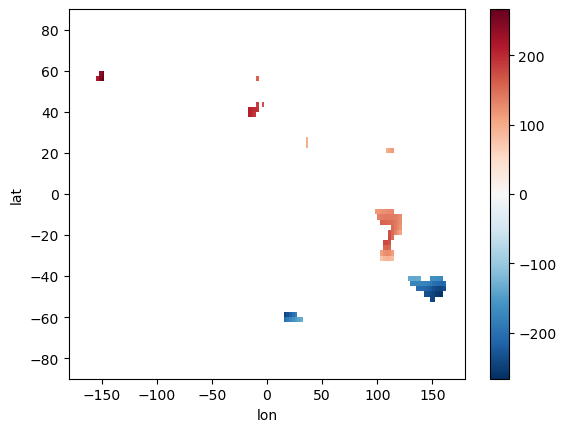

In [14]:
# Only Plot MSL Where Statistically Significant
p_psl_mask = ((obs_regs["p_psl"] < .10).sum(dim="model") < obs_regs.model.size/2)
# Replace Values True in p_psl_mask with np.nan
xr.where(p_psl_mask, np.nan, obs_regs["reg_psl"].mean("model")).plot()
p_psl_mask

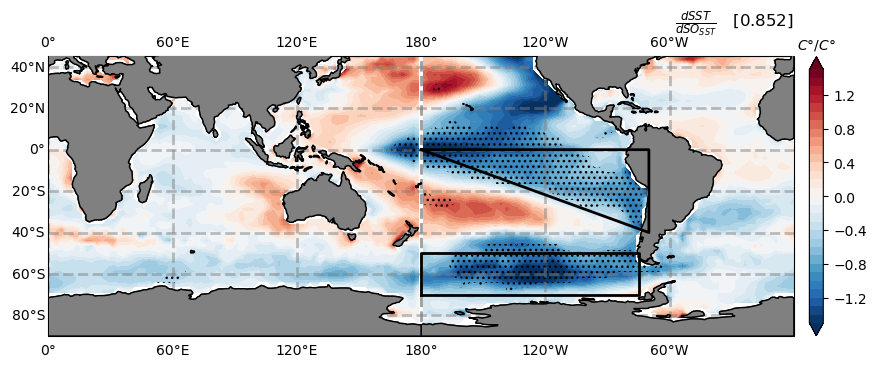

In [18]:
# Calculate the average of all maps
avg_reg = obs_sst_so_ept_reg.sel(years=12*5).reg.mean().values
axis_fontsize = 12
title_fontsize = 16

# Create a single plot
fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# Plot the average map
img = _global_plot(
    ax,
    data=-obs_regs["reg_sst"].mean("model"),
    lat=obs_regs["reg_sst"].latitude,
    lon=obs_regs["reg_sst"].longitude,
    levels=np.arange(-1.5, 1.6, .1),
    cmap="RdBu_r",
    cbar_label=r"$Wm^{-2}/C\degree$",
    pvalues=((obs_regs["p_sst"] < .10).sum(dim="model") < obs_regs.model.size/2),
    # contours=-obs_regs["reg_psl"].mean("model").values,
)

cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)
# ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   ", loc="right", fontsize=title_fontsize*.75)

ax.set_title(r"$\frac{dSST}{dSO_{SST}}$   " + f"[{np.around(avg_reg, 3)}]", loc="right", fontsize=title_fontsize*.75)
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_response_so_RdBu_obs-mean_no-psl.png")

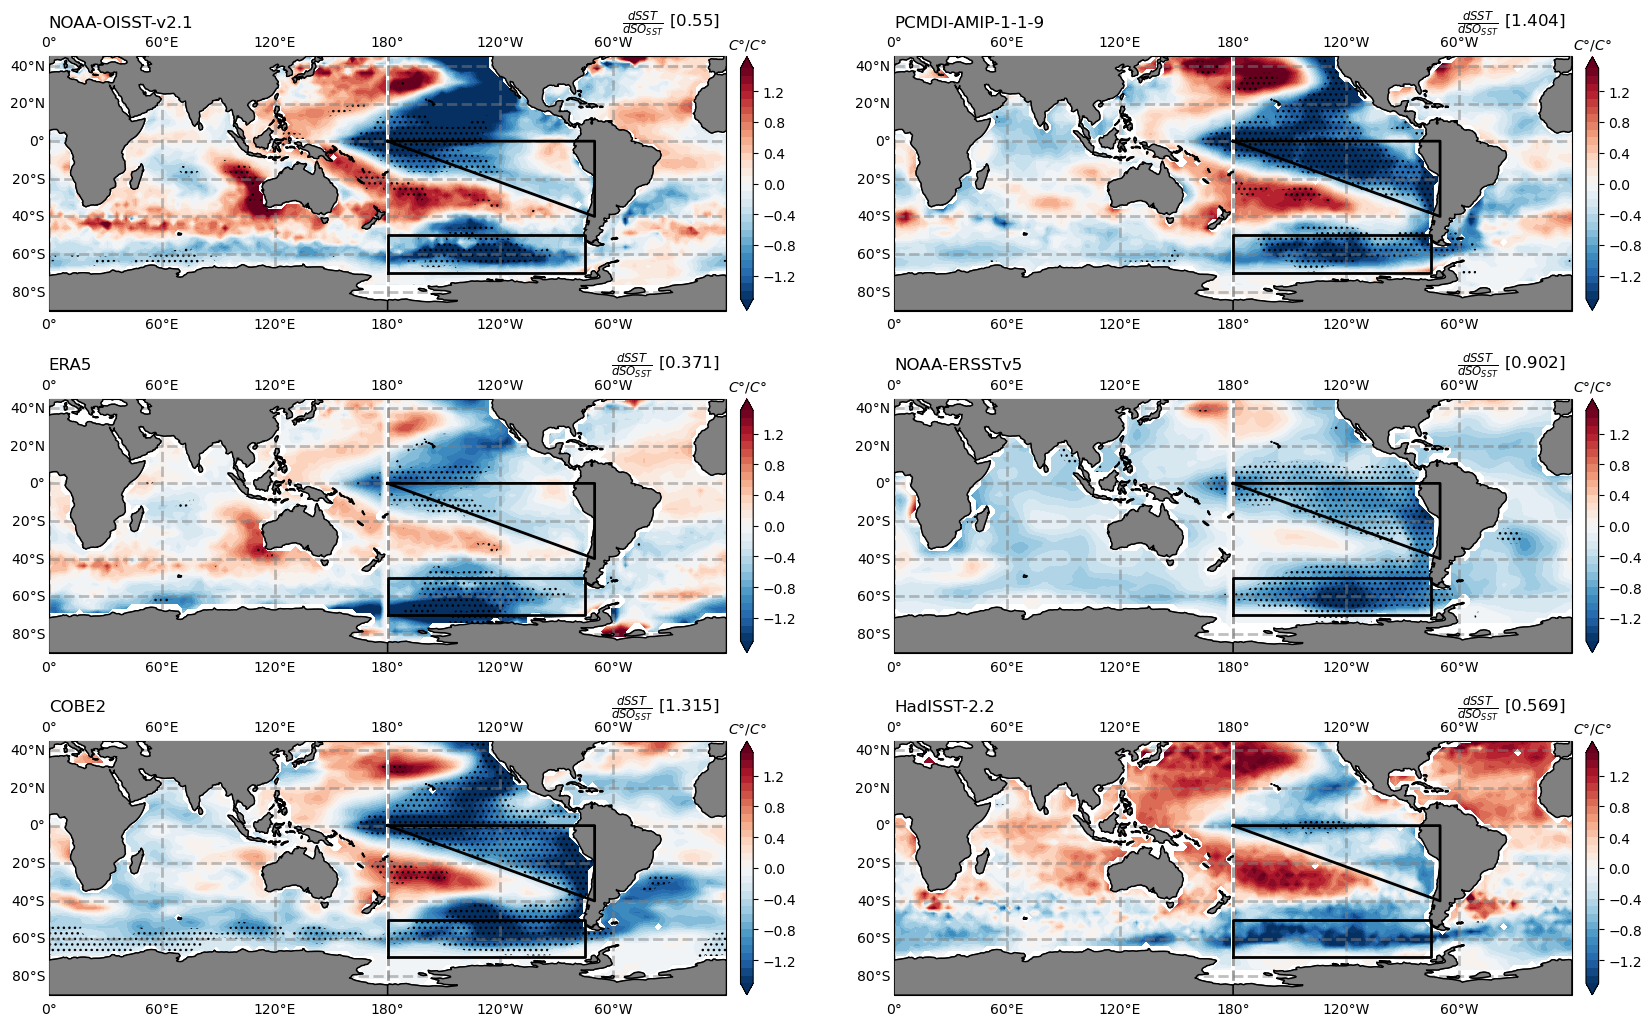

In [17]:
fig, axes = plt.subplots(3, 2, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})
# cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.7])
fig.subplots_adjust(hspace=-.60)
axis_fontsize = 12
title_fontsize = 16

for i, (ax, cmodel) in enumerate(zip(axes.flat, obs_regs["reg_sst"].model)):
    # Plot spatial map
    # if i == 0: 
    #     pass
        # continue
        # # Plot the average map
        # img = _global_plot(
        #     ax,
        #     data=-obs_sst_maps_reg.mean("model"),
        #     lat=obs_sst_maps_reg.latitude,
        #     lon=obs_sst_maps_reg.longitude,
        #     levels=np.arange(-2, 2.1, .1),
        #     cmap="RdYlBu_r",
        #     cbar_label=r"$Wm^{-2}/C\degree$",
        #     contours=-obs_psl_reg.mean("model").reg.values,
        # )

        # cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
        # cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)
        # ax.set_title(r"$\frac{dSST}{dSO_{SST}}$  " + f"[{np.around(avg_reg, 3)}]", loc="right", fontsize=title_fontsize*.75)
        # ax.set_title("Obs Avg", loc="left", fontsize=title_fontsize*.75)

    ax = axes.flat[i]
    img = _global_plot(
        ax,
        data=-obs_regs["reg_sst"].sel(model=cmodel),
        lat=obs_regs["reg_sst"].latitude,
        lon=obs_regs["reg_sst"].longitude,
        levels=np.arange(-1.5, 1.6, .1),
        cmap="RdBu_r",
        pvalues=obs_regs["p_sst"].sel(model=cmodel),
        cbar_label=r"$Wm^{-2}/C\degree$",
        # contours=-obs_regs["reg_psl"].sel(model=cmodel).values,
    )
    ax.set_title(r"$\frac{dSST}{dSO_{SST}}$" + f" [{np.around(obs_sst_so_ept_reg.sel(model=cmodel).sel(years=12*5).reg.values, 3)}]  ", loc="right", fontsize=title_fontsize*.75)
    ax.set_title(cmodel.values, loc="left", fontsize=title_fontsize*.75)
    cbar = plt.colorbar(img, ax=ax, orientation="vertical", fraction=.018, pad=0.02)
    cbar.ax.set_title(r"$C\degree/C\degree$", fontsize=10)

# fig.delaxes(axes.flat[-1])
plt.savefig("/home/espinosa10/SO-EP-teleconnection/Figures/sst_response_so_RdBu_obs_no-psl.png")

# Lagged Analysis

In [ ]:
def lagged_regression(ts_so_ssts, ts_ept_ssts, lags):
    reg_coeffs, rvalues, pvalues = [], [], []
    for lag in lags:
        rvalues.append(xscore.pearson_r(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        reg_coeffs.append(xscore.linslope(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))
        pvalues.append(xscore.pearson_r_eff_p_value(ts_so_ssts.shift(time=lag), ts_ept_ssts, dim="time", skipna=True))

    reg_coeffs = xr.Dataset({'reg': (['lags', 'model'], np.array(reg_coeffs))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    rvalues = xr.Dataset({'rvalues': (['lags', 'model'], np.array(rvalues))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    pvalues = xr.Dataset({'pvalues': (['lags', 'model'], np.array(pvalues))}, coords={'model': ts_so_ssts.model, 'lags': lags})
    # Combine to xr.Datasets into one
    regs_dataset = xr.merge([rvalues, reg_coeffs, pvalues])
    return regs_dataset

lags = np.arange(-12*5, 12*5)
window = 12
lagged_so_ept_coupling = []
for cmodel in obs_sst_all.model:
    so_cmodel = obs_sst_all.sel(model=[cmodel.values])["Raw_SO_Mean"]
    ept_cmodel = obs_sst_all.sel(model=[cmodel.values])["Raw_EPT_Mean"]
    so_rolling = get_rolling_timeseries(so_cmodel, window=window, step=1, gradient=False)
    ept_rolling = get_rolling_timeseries(ept_cmodel, window=window, step=1, gradient=False)
    lagged_so_ept_coupling.append(lagged_regression(so_rolling, ept_rolling, lags))

lagged_so_ept_coupling = xr.concat(lagged_so_ept_coupling, dim="model")
# lagged_so_ept_coupling.to_netcdf("/home/espinosa10/SO-EP-teleconnection/Data/lagged_so_ept_coupling_obs.nc")

<xarray.Dataset>
Dimensions:  (lags: 120, model: 6)
Coordinates:
  * model    (model) <U16 'NOAA-OISST-v2.1' 'PCMDI-AMIP-1-1-9' ... 'HadISST-2.2'
  * lags     (lags) int64 -60 -59 -58 -57 -56 -55 -54 ... 53 54 55 56 57 58 59
Data variables:
    rvalues  (lags, model) float64 0.08662 -0.01206 0.2198 ... -0.05078 0.0345
    reg      (lags, model) float64 0.1789 -0.03685 0.3211 ... -0.1496 0.06895
    pvalues  (lags, model) float64 0.9134 0.966 0.7802 ... 0.9063 0.8519 0.9483

# Precip Reg Coeffs

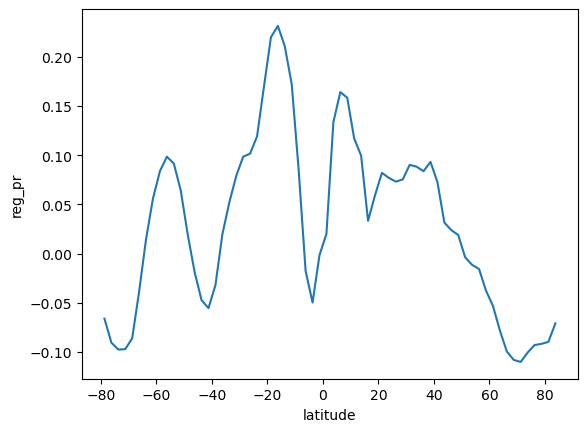

In [53]:
# Apply rolling mean with a window size of 5 degrees latitude
smoothed_data = (-obs_regs["reg_pr"].mean(["longitude", "model"])*1000).rolling(latitude=5, center=True).mean()

# Plot the smoothed data
smoothed_data.plot()

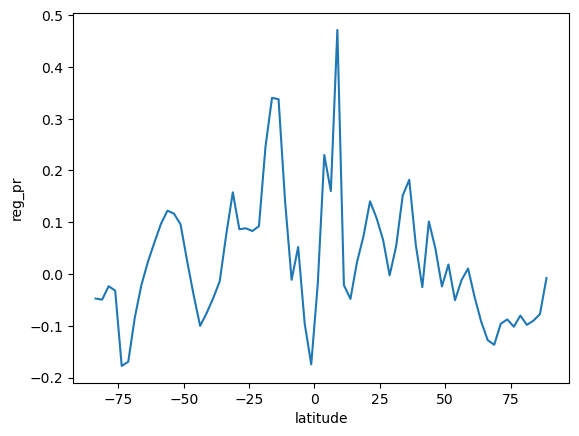

In [52]:
# (-obs_pr_reg.mean(["longitude", "model"])*1000).reg.plot()
# How do I smooth this line
(-obs_regs["reg_pr"].mean(["longitude", "model"])*1000).plot()

# Walker Reg Coeffs

# WE Reg Coeffs